In [94]:
# Library imports
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import random

from image_utils import *
from scipy.ndimage import label
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation as R

data_path = os.path.join("boneMRI", "20240119_BoneMRI_EBS23")
segmentation_path = os.path.join("boneMRI", "20240119_BoneMRI_EBS23_Segmentation.nii")

The shape of the image is (100, 672, 672)


Text(0.5, 1.0, 'Applied segmentation mask')

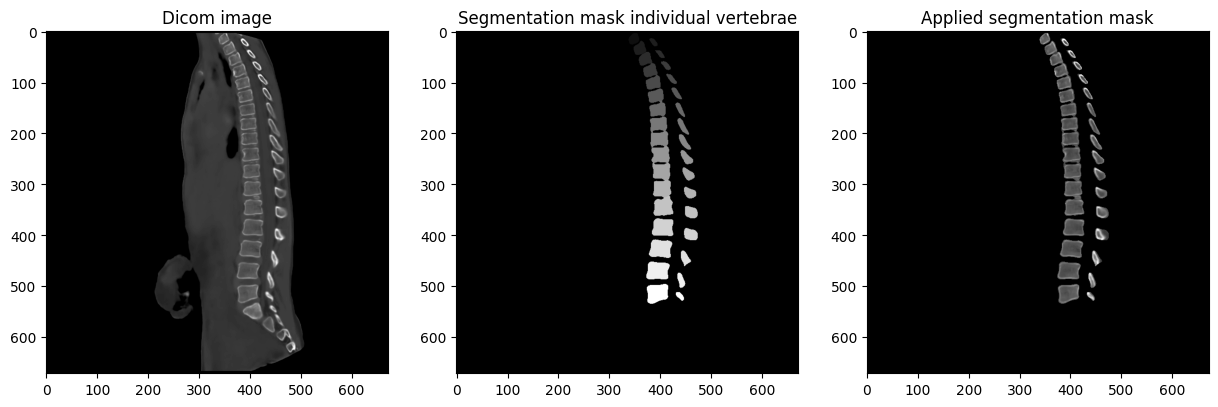

In [95]:
## Loading the data
# Load segmentation data
segment = nib.load(segmentation_path)
segment_data = np.transpose(segment.get_fdata())
segment_header = segment.header
segment_all = segment_data > 0

# Load dicom data and apply windowing
dicom_image = load_3d_dicom(data_path)
dicom_image = apply_window(dicom_image, window_level=450, window_width=1500)
segment_dicom_image = dicom_image*segment_all
print(f"The shape of the image is {dicom_image.shape}")

# Plot data 
slice_index = 50  # Middle slice along the z-axis
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(dicom_image[slice_index, :, :], cmap='gray')
ax[0].set_title("Dicom image")
ax[1].imshow(segment_data[slice_index, :, :], cmap='gray')
ax[1].set_title("Segmentation mask individual vertebrae")
ax[2].imshow(segment_dicom_image[slice_index, :, :], cmap='gray')
ax[2].set_title("Applied segmentation mask")

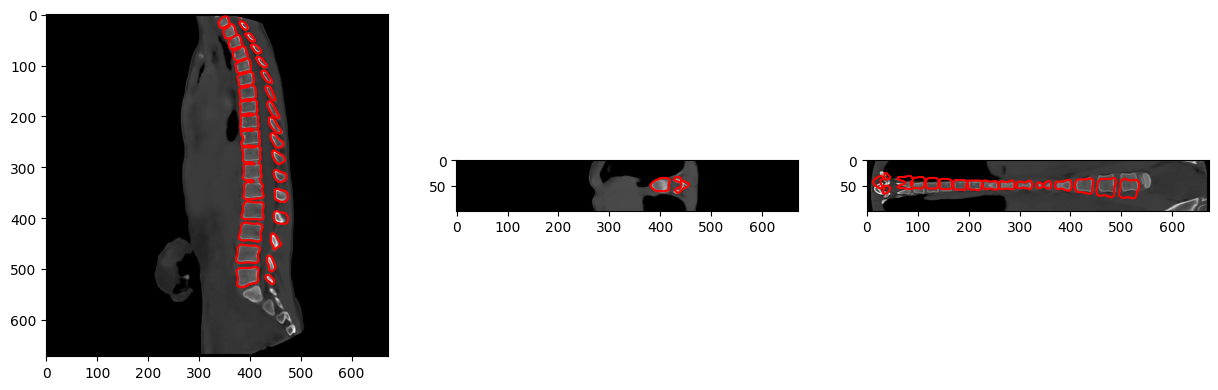

In [96]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(dicom_image[50, :, :], cmap='gray')
ax[0].contour(segment_data[50, :, :], levels=[0.5], colors='r', linewidths=1.5)
ax[1].imshow(dicom_image[:, 220, :], cmap='gray')
ax[1].contour(segment_data[:, 220, :], levels=[0.5], colors='r', linewidths=1.5)
ax[2].imshow(dicom_image[:, :, 390], cmap='gray')
ax[2].contour(segment_data[:, :, 390], levels=[0.5], colors='r', linewidths=1.5)

# Calculate Oriented Bounding Box and Angles

In [97]:
import scipy.spatial.transform as transform
# Function to get Oriented Bounding Box
def compute_obb(binary_volume):
    """
    Compute the oriented bounding box (OBB) and its rotation angles.
    
    Parameters:
        binary_volume (numpy.ndarray): A 3D binary volume.

    Returns:
        obb_corners (numpy.ndarray): 8 corners of the oriented bounding box.
        rotation_matrix (numpy.ndarray): 3x3 rotation matrix.
        euler_angles (tuple): (yaw, pitch, roll) in degrees.
    """
    """
    Compute the oriented bounding box (OBB) and its rotation angles.

    Parameters:
        binary_volume (numpy.ndarray): A 3D binary volume.

    Returns:
        obb_corners (numpy.ndarray): 8 corners of the oriented bounding box.
        rotation_matrix (numpy.ndarray): 3x3 rotation matrix.
        euler_angles (tuple): (yaw, pitch, roll) in degrees.
    """
    # Get voxel coordinates of the foreground (object) pixels
    coords = np.argwhere(binary_volume)
    centroid = coords.mean(axis=0)
    centered_coords = coords - centroid
    
    # Apply PCA to determine the best-fit axes
    cov_matrix = np.cov(centered_coords, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)
    
    # Ensure right-handed coordinate system
    eigvecs[:, 2] = np.cross(eigvecs[:, 0], eigvecs[:, 1])
    
    # Convert eigenvectors to Euler angles (ZYX order: yaw, pitch, roll)
    r_matrix = eigvecs.T  # Rotation matrix
    r = transform.Rotation.from_matrix(r_matrix)
    euler_angles = r.as_euler('ZYX', degrees=True)  # Yaw, Pitch, Roll
    
    # Ensure angles are between -45 and 45 degrees
    euler_angles = np.array([(((a + 45)  % 90) - 45) for a in euler_angles])
    
    # Constrain yaw within ±5 degrees
    constrained_yaw = np.clip(euler_angles[0], -5, 5)
    constrained_pitch =  euler_angles[1]
    constrained_roll = euler_angles[2]
    
    # Reconstruct constrained rotation matrix
    constrained_r = transform.Rotation.from_euler(
        'ZYX', [constrained_yaw, constrained_pitch, constrained_roll], degrees=True
    ).as_matrix()
    
    # Get min/max bounding box in the constrained coordinate system
    transformed_coords = centered_coords @ constrained_r.T
    min_coords = transformed_coords.min(axis=0)
    max_coords = transformed_coords.max(axis=0)
    
    # Compute OBB corners in the original coordinate system
    obb_corners = np.array([
        [min_coords[0], min_coords[1], min_coords[2]],
        [max_coords[0], min_coords[1], min_coords[2]],
        [max_coords[0], max_coords[1], min_coords[2]],
        [min_coords[0], max_coords[1], min_coords[2]],
        [min_coords[0], min_coords[1], max_coords[2]],
        [max_coords[0], min_coords[1], max_coords[2]],
        [max_coords[0], max_coords[1], max_coords[2]],
        [min_coords[0], max_coords[1], max_coords[2]]
    ]) @ constrained_r + centroid
    
    return obb_corners, centered_coords, constrained_r, [constrained_yaw, constrained_pitch, constrained_roll]


def visualize_bounding_boxes(image_3d, obb_corners_input):
    """
    Visualize multiple oriented bounding boxes over the original 3D image.

    Parameters:
        image_3d (numpy.ndarray): A 3D image (grayscale or binary).
        obb_corners_dict (dict): Dictionary where keys are labels and values are 8x3 arrays of OBB corners.
    """
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Extract voxel positions where image intensity > 0
    coords = np.argwhere(image_3d > 0)
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='gray', alpha=0.1, s=1)

    # Define edges of bounding box
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),  # Bottom face
        (4, 5), (5, 6), (6, 7), (7, 4),  # Top face
        (0, 4), (1, 5), (2, 6), (3, 7)   # Vertical edges
    ]
    
    # Check if input is a dictionary or a single bounding box array
    if isinstance(obb_corners_input, dict):
        obb_corners_dict = obb_corners_input
    else:
        obb_corners_dict = {"Single OBB": obb_corners_input}  # Wrap in a dict with a default label
    
    for label, obb_corners in obb_corners_dict.items():
        color = [random.random() for _ in range(3)]  # Generate a random RGB color
        for edge in edges:
            p1, p2 = obb_corners[edge[0]], obb_corners[edge[1]]
            ax.plot(*zip(*[p1, p2]), color=color, label=label if edge == (0, 1) else "")
    
    # Get limits
    x_limits = [coords[:, 0].min(), coords[:, 0].max()]
    y_limits = [coords[:, 1].min(), coords[:, 1].max()]
    z_limits = [coords[:, 2].min(), coords[:, 2].max()]
    
    # Set equal scaling
    max_range = np.array([x_limits, y_limits, z_limits]).ptp().max() / 2.0
    mid_x = np.mean(x_limits)
    mid_y = np.mean(y_limits)
    mid_z = np.mean(z_limits)

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    # Set labels
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.title("Oriented Bounding Boxes on 3D Image")
    plt.legend()
    plt.show()

In [98]:
# Obtain unique labels for the vertebrae (skipping zero, assuming background is 0)
vertebrae_labels = np.unique(segment_data)
vertebrae_labels = vertebrae_labels[vertebrae_labels > 0]  # Exclude background (0)

# Store results for each vertebra
bounding_boxes = {}
rotation_matrices = {}
euler_angles_dict = {}
centeroids = {}
cropped_volumes = {}

# Get the shape of the 3D volume
depth, height, width = dicom_image.shape

for label in vertebrae_labels:
    # Create a binary mask for the specific vertebra
    binary_volume = (segment_data == label).astype(np.uint8)

    # Compute the oriented bounding box (OBB)
    obb_corners, centeroid, rotation_matrix, euler_angles = compute_obb(binary_volume)
    
    # Compute the Axis-Aligned Bounding Box (AABB) from OBB corners
    min_coords = np.min(obb_corners, axis=0).astype(int)
    max_coords = np.max(obb_corners, axis=0).astype(int)
    min_coords = np.clip(min_coords, 0, [depth-1, height-1, width-1])
    max_coords = np.clip(max_coords, 0, [depth-1, height-1, width-1])

    # Extract the cropped volume for the vertebra
    cropped_volume = dicom_image[min_coords[0]:max_coords[0]+1, 
                                 min_coords[1]:max_coords[1]+1, 
                                 min_coords[2]:max_coords[2]+1]
    
    cropped_volumes[label] = cropped_volume  # Store cropped ROI

    # Store results
    bounding_boxes[label] = obb_corners
    centeroids[label] = centeroids
    rotation_matrices[label] = rotation_matrix
    euler_angles_dict[label] = euler_angles
    
    print(f"Vertebra {label}:")
    print(f"  Angle 0 (Y-axis): {euler_angles_dict[label][0]:.2f} degrees")
    print(f"  Angle 1 (Z-axis): {euler_angles_dict[label][1]:.2f} degrees")
    print(f"  Angle 2 (X-axis): {euler_angles_dict[label][2]:.2f} degrees")

print(f"Computed bounding box for {len(vertebrae_labels)} vertebra")

Vertebra 1.0:
  Angle 0 (Y-axis): 5.00 degrees
  Angle 1 (Z-axis): 10.25 degrees
  Angle 2 (X-axis): -29.33 degrees
Vertebra 2.0:
  Angle 0 (Y-axis): -0.02 degrees
  Angle 1 (Z-axis): 0.66 degrees
  Angle 2 (X-axis): -25.39 degrees
Vertebra 3.0:
  Angle 0 (Y-axis): -0.07 degrees
  Angle 1 (Z-axis): 2.35 degrees
  Angle 2 (X-axis): -25.26 degrees
Vertebra 4.0:
  Angle 0 (Y-axis): 1.83 degrees
  Angle 1 (Z-axis): -0.02 degrees
  Angle 2 (X-axis): -20.93 degrees
Vertebra 5.0:
  Angle 0 (Y-axis): 1.16 degrees
  Angle 1 (Z-axis): 0.55 degrees
  Angle 2 (X-axis): -16.05 degrees
Vertebra 6.0:
  Angle 0 (Y-axis): -0.11 degrees
  Angle 1 (Z-axis): 1.07 degrees
  Angle 2 (X-axis): -11.07 degrees
Vertebra 7.0:
  Angle 0 (Y-axis): -5.00 degrees
  Angle 1 (Z-axis): -0.40 degrees
  Angle 2 (X-axis): -6.57 degrees
Vertebra 8.0:
  Angle 0 (Y-axis): -5.00 degrees
  Angle 1 (Z-axis): -0.08 degrees
  Angle 2 (X-axis): -3.48 degrees
Vertebra 9.0:
  Angle 0 (Y-axis): -5.00 degrees
  Angle 1 (Z-axis): -0.94

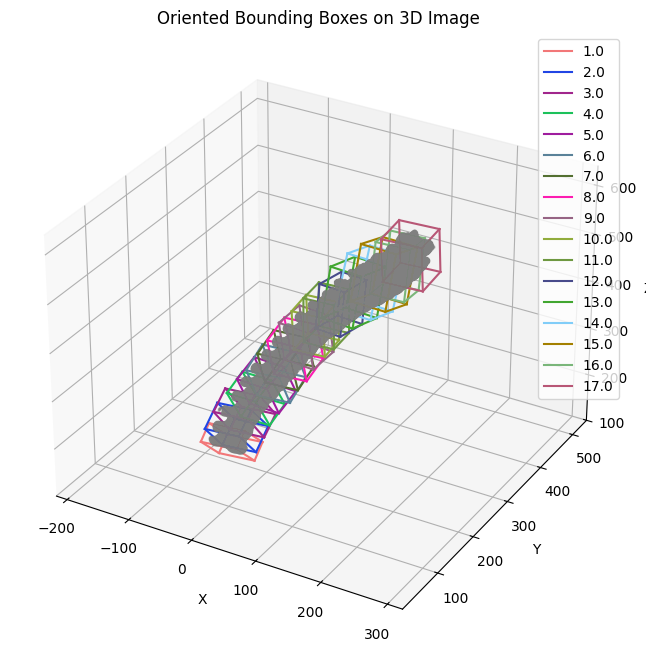

In [91]:
visualize_bounding_boxes(segment_data, bounding_boxes)

Vertebra 13.0:
  (Y-axis): -5.00 degrees
  (Z-axis): -1.55 degrees
  (X-axis): 5.37 degrees



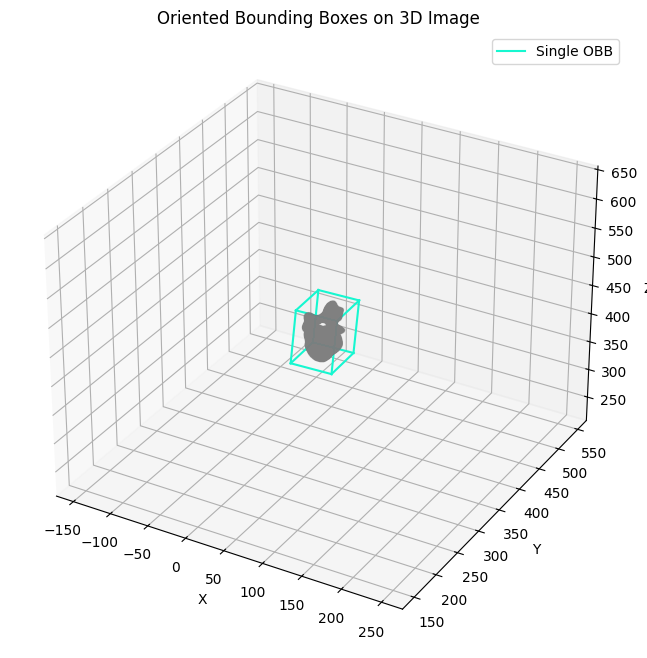

In [99]:
# Display result
label = 13.0
print(f"Vertebra {label}:")
print(f"  (Y-axis): {euler_angles_dict[label][0]:.2f} degrees")
print(f"  (Z-axis): {euler_angles_dict[label][1]:.2f} degrees")
print(f"  (X-axis): {euler_angles_dict[label][2]:.2f} degrees")
print()

# Visualize the bounding box for each vertebra
segment = (segment_data == label).astype(np.uint8)
visualize_bounding_boxes(segment, bounding_boxes[label])

# Validation

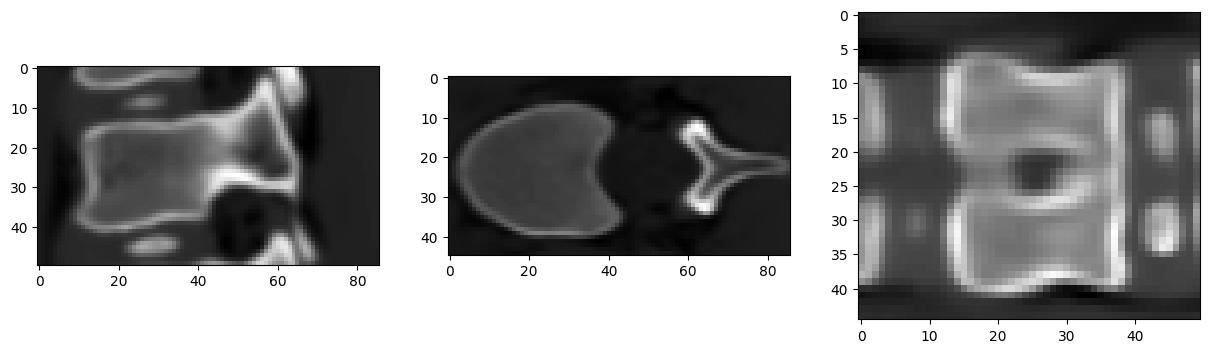

In [102]:
label = 12

# Plot Region of Interest
slice_index = 35  # Middle slice along the z-axis
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cropped_volumes[label][slice_index, :, :], cmap='gray')
ax[1].imshow(cropped_volumes[label][:, slice_index, :], cmap='gray')
ax[2].imshow(cropped_volumes[label][:, :, slice_index], cmap='gray')

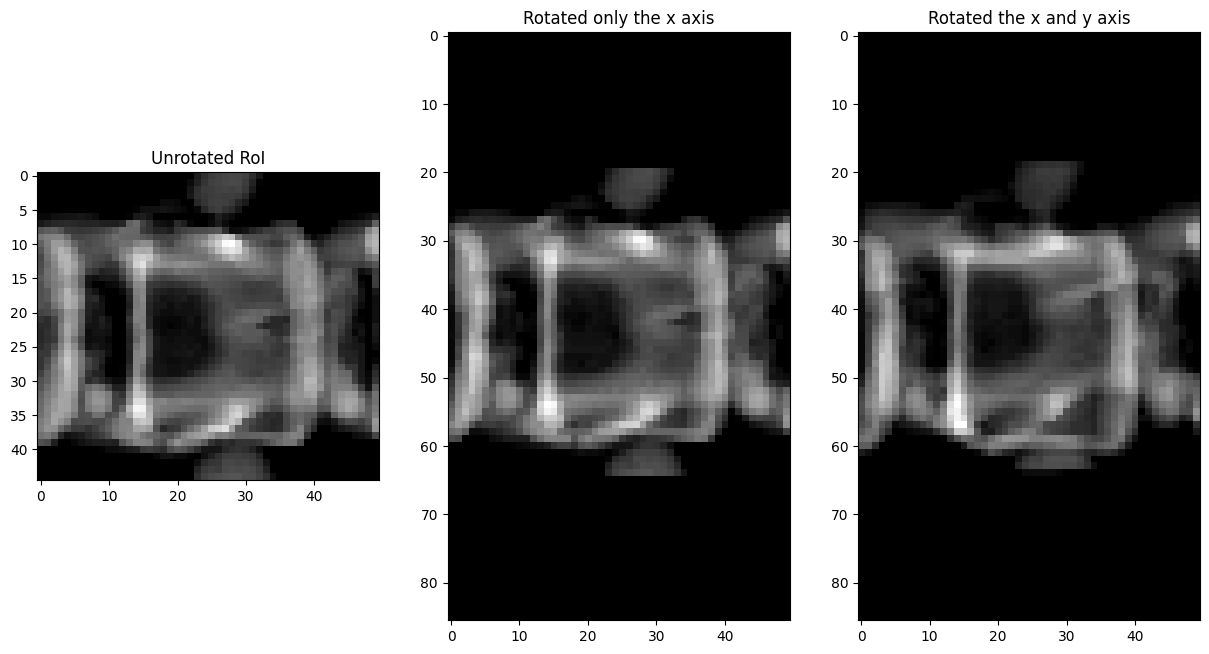

In [103]:
# Rotate according to optimal angle
angle = euler_angles_dict[label]
spine_segment = cropped_volumes[label].copy()

# only x axis
spine_segment = rotate_image(spine_segment, axis=0, angle=-angle[2])
compressed_rotated_spine1 = compress_bonemri(spine_segment, axis=2)

# x and z axis
spine_segment_xz = rotate_image(spine_segment, axis=1, angle=angle[0])
compressed_rotated_spine2 = compress_bonemri(spine_segment_xz, axis=2)

# original image
compressed_dicom_image = compress_bonemri(cropped_volumes[label], axis=2)

# Plot data
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].imshow(compressed_dicom_image, cmap='gray')
ax[0].set_title("Unrotated RoI")
ax[1].imshow(compressed_rotated_spine1, cmap='gray')
ax[1].set_title("Rotated only the x axis")
ax[2].imshow(compressed_rotated_spine2, cmap='gray')
ax[2].set_title("Rotated the x and y axis")

plt.show()